In [1]:
import epidemiology.secir as secir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date

In [2]:
#import seaborn as sns
#plt.style.use("seaborn")

In [3]:
from utils_SA import simulate_model

In [4]:
# openturns libraries

from __future__ import print_function
import openturns as ot
import openturns.viewer as viewer
from matplotlib import pylab as plt
ot.Log.Show(ot.Log.NONE)

In [5]:
# define static parameters of the model

# Define Comartment names
compartments = ['Susceptible', 'Exposed', 'Carrier', 'Infected', 'Hospitalized', 'ICU', 'Recovered', 'Dead']
# Define age Groups
groups = ['0-4', '5-14', '15-34', '35-59', '60-79', '80+']
# Define population of age groups
populations = [40000, 70000, 190000, 290000, 180000, 60000] 

days = 100 # number of days to simulate
start_day = 1
start_month = 1
start_year = 2019
dt = 0.1
num_groups = len(groups)
num_compartments = len(compartments)

# set contact frequency matrix
baseline_contact_matrix0 = "../../data/contacts/baseline_home.txt"
baseline_contact_matrix1 = "../../data/contacts/baseline_school_pf_eig.txt"
baseline_contact_matrix2 = "../../data/contacts/baseline_work.txt"
baseline_contact_matrix3 = "../../data/contacts/baseline_other.txt"

baseline_contact_matrix = np.loadtxt(baseline_contact_matrix0) \
        + np.loadtxt(baseline_contact_matrix1) \
        + np.loadtxt(baseline_contact_matrix2) + np.loadtxt(baseline_contact_matrix3)

minimum_contact_matrix = np.ones((num_groups, num_groups)) * 0

In [6]:
static_params = {
    'num_groups': num_groups, 
    'num_compartments': num_compartments,
    'populations': populations,
    'start_day' : (date(start_year, start_month, start_day) - date(start_year, 1, 1)).days,
    'baseline_contact_matrix' : baseline_contact_matrix, 
    'minimum_contact_matrix' : minimum_contact_matrix,
    'damping_coeff' : 0.9, 
    'days' : days,
    'dt' : dt,
    # which compartment's maximal value should be outputed?
    'output_index' : compartments.index("Infected") 
}


In [7]:
# define input factors and their distributions

input_factor_names = ["incubation_time", 
                 "infectious_mild_time", 
                 "serial_interval", 
                 "hospitalized_to_home_time", 
                 "home_to_hospitalized_time",
                 "hospitalized_to_icu_time", 
                 "icu_to_home_time", 
                 "icu_to_death_time"
                ]

dimension = len(input_factor_names)

coll = [ot.Uniform(4, 6),
         ot.Uniform(4, 8),
         ot.Uniform(3.5, 5.5),
         ot.Normal(9, 4),
         ot.Normal(7, 4),
         ot.Normal(3, 4),
         ot.Normal(9, 4),
         ot.Normal(8, 4)]


In [8]:
inputDistribution = ot.ComposedDistribution(coll)
inputDistribution.setDescription(input_factor_names)

size = 1000

sie = ot.SobolIndicesExperiment(inputDistribution, size)

# generate samples from the input distribution
inputDesign = sie.generate()
input_names = inputDistribution.getDescription()
inputDesign.setDescription(input_names)

print("Sample size: ", inputDesign.getSize())

Sample size:  10000


In [9]:
i = 1
sampled_params = dict(zip(input_factor_names, inputDesign[i]))
params = {**sampled_params, **static_params}
params

{'incubation_time': 5.765610447438521,
 'infectious_mild_time': 4.604451661380891,
 'serial_interval': 4.275532308862244,
 'hospitalized_to_home_time': 5.146420070929398,
 'home_to_hospitalized_time': 11.361762176518251,
 'hospitalized_to_icu_time': 3.1780337507754624,
 'icu_to_home_time': 10.527974046497274,
 'icu_to_death_time': 3.8065736271209483,
 'num_groups': 6,
 'num_compartments': 8,
 'populations': [40000, 70000, 190000, 290000, 180000, 60000],
 'start_day': 0,
 'baseline_contact_matrix': array([[3.9547, 1.1002, 2.9472, 2.05  , 0.3733, 0.0445],
        [0.3327, 3.5892, 1.236 , 1.9208, 0.2681, 0.0161],
        [0.246 , 0.7124, 5.6518, 3.2939, 0.2043, 0.0109],
        [0.1742, 0.8897, 3.3124, 4.5406, 0.4262, 0.0214],
        [0.0458, 0.1939, 0.5782, 1.3825, 1.473 , 0.0704],
        [0.1083, 0.1448, 0.4728, 0.9767, 0.6266, 0.1724]]),
 'minimum_contact_matrix': array([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0.,

In [11]:
Y = simulate_model(params)
print(Y)

102723.41005083271


In [12]:
output = []
for i in range(inputDesign.getSize()):
    sampled_params = dict(zip(input_factor_names, inputDesign[i]))
    Y = simulate_model({**sampled_params, **static_params})
    output.append([Y])
#print(output)
outputDesign = ot.Sample(output)

In [13]:
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

In [14]:
output_dimension = 1
for i in range(output_dimension):
    print("Output #", i)
    first_order = sensitivityAnalysis.getFirstOrderIndices(i)
    total_order = sensitivityAnalysis.getTotalOrderIndices(i)
    print("    First order indices: ", first_order)
    print("    Total order indices: ", total_order)

agg_first_order = sensitivityAnalysis.getAggregatedFirstOrderIndices()
agg_total_order = sensitivityAnalysis.getAggregatedTotalOrderIndices()
print("Agg. first order indices: ", agg_first_order)
print("Agg. total order indices: ", agg_total_order)

Output # 0
    First order indices:  [0.150296,0.298543,0.0199348,0.0152312,0.537038,0.0152728,0.015266,0.0152681]
    Total order indices:  [0.114418,0.329917,0.0062278,-1.20765e-06,0.54032,5.13112e-06,4.84183e-06,2.08463e-05]
Agg. first order indices:  [0.150296,0.298543,0.0199348,0.0152312,0.537038,0.0152728,0.015266,0.0152681]
Agg. total order indices:  [0.114418,0.329917,0.0062278,-1.20765e-06,0.54032,5.13112e-06,4.84183e-06,2.08463e-05]


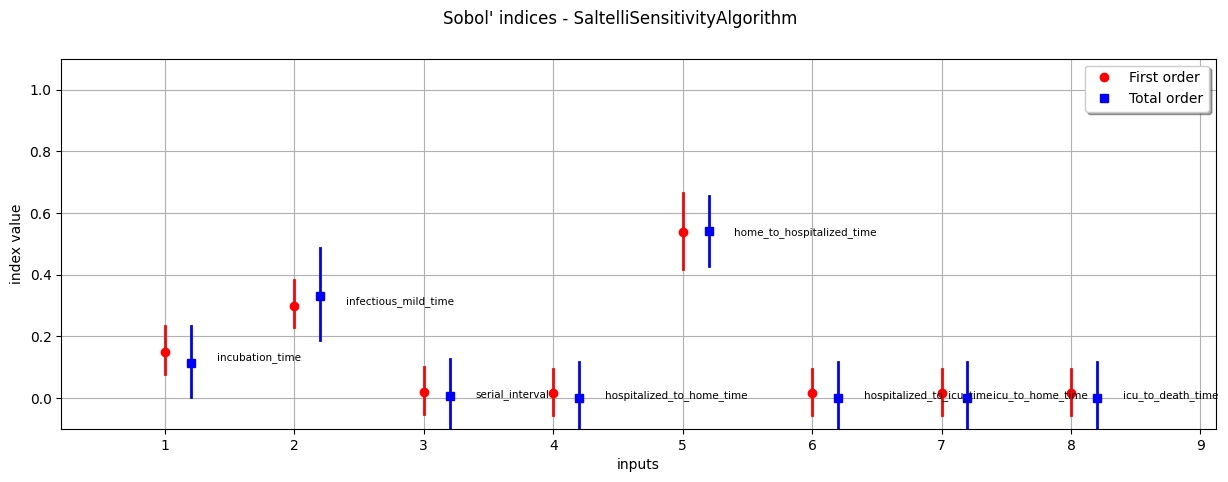

In [15]:
graph = sensitivityAnalysis.draw()
view = viewer.View(graph, (1500, 500))

In [13]:
# num_groups
# num_compartments
# start_date = (date(start_year, start_month, start_day) - date(start_year, 1, 1)).days
# baseline_contact_matrix = baseline_contact_matrix, 
# minimum_contact_matrix = minimum_contact_matrix
# damping_coeff
# damping_time
# damping_level
# daming_type
# days
# dt
# output_index = compartments.index("Infected") -> hard coded